(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
         0.,  0.,  2.,  1.,  3.,  5.,  4.,  4.,  4.,  6.,  2.,  1.,  5.,
         7.,  5.,  6., 10.,  7.,  8., 10., 11., 10.,  9., 24., 13., 19.,
        18., 17., 25., 24., 30., 21., 22., 23., 21., 29., 28., 24., 28.,
        20., 32., 25., 30., 26., 21., 18., 21., 20., 17., 20., 17., 13.,
        18., 15., 10., 10., 15., 11., 15., 12., 14., 10.,  7., 11., 19.,
         8.,  6.,  9., 11.,  6.,  6.,  1.,  2.,  2.,  1.,  0.,  1.,  0.,
         1.,  2.,  1.,  0.,  0.,  2.,  2.,  0.,  1.]),
 array([0.16662244, 0.17288133, 0.17914023, 0.18539912, 0.19165802,
        0.19791692, 0.20417581, 0.21043471, 0.2166936 , 0.2229525 ,
        0.2292114 , 0.23547029, 0.24172919, 0.24798808, 0.25424698,
        0.26050587, 0.26676477, 0.27302367, 0.27928256, 0.28554146,
        0.29180035, 0.29805925, 0.30431815, 0.31057704, 0.31683594,
        0.32309483, 0.32935373, 0.33561262, 0.34187152, 0.34813042,
        0.35438931, 0.3606

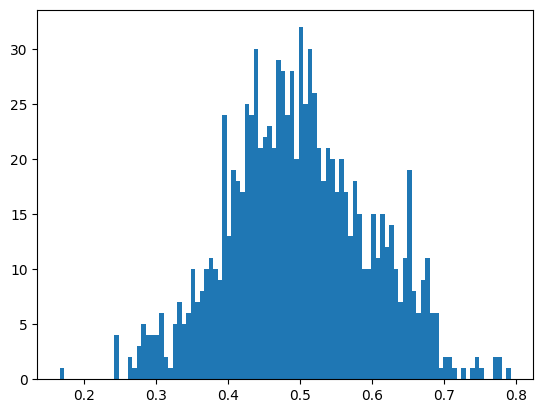

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Number of agents
N = 1000

# Wealth
wealth_arr = abs(np.random.normal(0.5, 0.1, N))
plt.hist(wealth_arr, bins=100)  

In [61]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

gini(wealth_arr)

np.float64(0.11215490850097454)

In [62]:
X = wealth_arr
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]


(np.float64(0.0), np.float64(1.0000000000000002))

Text(0.5, 1.0, 'Lorenz curve')

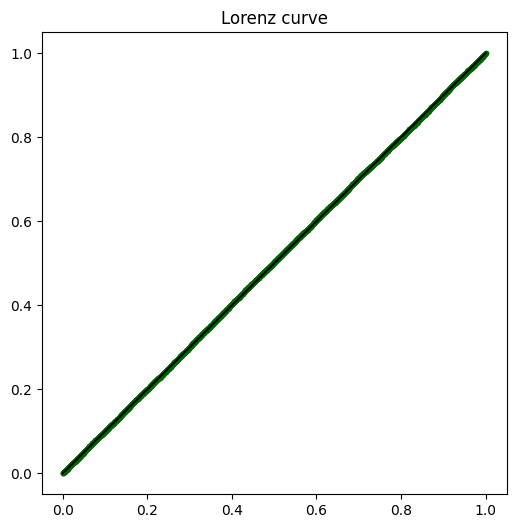

In [63]:
fig, ax = plt.subplots(figsize=[6,6])

ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='darkgreen', s=10)
ax.plot([0,1], [0,1], color='k')
ax.set_title('Lorenz curve')
 

In [64]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class PotentialCriminal(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = model.wealth_arr[unique_id]
        self.criminal = False
        self.wealth = model.wealth_arr[unique_id]
        
    def step(self):
        if self.criminal:  
            return

        other_agent = self.random.choice(self.model.schedule.agents)

        if other_agent.wealth - self.wealth > self.model.deterrence:
            self.criminal = True

           # stolen_amount = self.random.random() * other_agent.wealth
            #self.wealth += stolen_amount 
            #other_agent.wealth -= stolen_amount
        
        return

def get_crime_rate(model):
    agent_out = [agent.criminal for agent in model.schedule.agents]
    return sum(agent_out)/model.num_agents
    

class CrimeModel(Model):
    def __init__(self, N, deterrence, wealth_arr):
        self.num_agents = N
        self.deterrence = deterrence
        self.wealth_arr = wealth_arr
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Crime rate": get_crime_rate},
            agent_reporters={"Criminal": "criminal"}
        )
        
        for i in range(self.num_agents):
            a = PotentialCriminal(i, self)
            self.schedule.add(a)
    
    def crime_rate(self):
        return sum([a.criminal for a in self.schedule.agents])/self.num_agents
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [65]:
model = CrimeModel(N, 0.5, wealth_arr)

while model.schedule.steps < 100:
    model.step()


C:\Users\nxg05271\AppData\Local\Temp\ipykernel_22660\4166095683.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [66]:
model.datacollector.get_agent_vars_dataframe()

Criminal
Step AgentID          
0    0           False
     1           False
     2           False
     3           False
     4           False
...                ...
99   492         False
     625         False
     639         False
     299         False
     97          False

[100000 rows x 1 columns]

In [67]:
model.datacollector.get_model_vars_dataframe()

,Crime rate
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
...,...
95,0.002
96,0.002
97,0.002
98,0.002


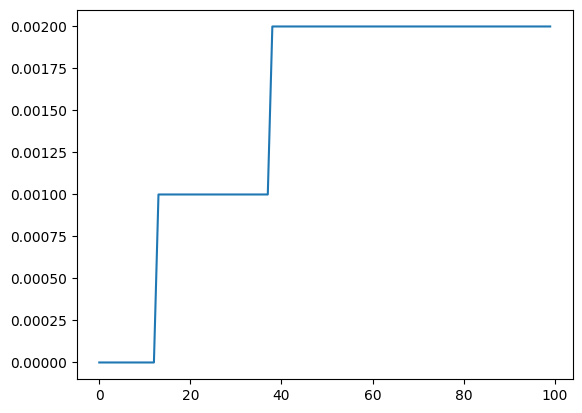

In [68]:
plt.plot(model.datacollector.get_model_vars_dataframe())